# **Malaria Detection**

## <b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
In 2019, 400K deaths related to malaria were reported with 229 million cases around the world. Manual microscopy for diagnostics purposes is labor intensive and time-consuming. During epidemics this can become a serious issue.
**The objectives:** What is the intended goal?<br>
The goal of this project is to develop a Deep Learning model that can accurately predict the presence of plasmodium parasite in red blood cell images taken through microscope.
**The key questions:** What are the key questions that need to be answered?<br>
1. Do deep learning models help predict presence of plasmodium parasite in red blood cell images accurately?
2. Are such model feasible to deploy?
3. What would be the impact of such model on public health and diagnostics costs?

**The problem formulation:** What is it that we are trying to solve using data science?
- We are trying to solve for scaling malaria detection in microsopy to make the process more reliable, faster, and cheaper.

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


### <b> Mount the Drive

In [1]:
#pip install opencv-python

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings('ignore')

### <b>Loading libraries</b>

In [4]:
import pandas as pd
import numpy as np

import os

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

import cv2

import zipfile

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
print(tf.__version__)

2.18.0


### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [6]:
'''
#path = 'cell_images.zip'
path = '/content/drive/MyDrive/Data Science/MIT Bootcamp/cell_images_2.zip'

#os.listdir(path)

try:
  with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Data Science/MIT Bootcamp/')
except Exception as e:
  print(e)
'''

In [7]:
#!unzip '/content/drive/MyDrive/Data Science/MIT Bootcamp/cell_images_2.zip' -d '/content/drive/MyDrive/Data Science/MIT Bootcamp/cell_images_3'

#### Visualize a sample image

In [8]:
#folder_path = 'cell_images'
folder_path= '/content/drive/MyDrive/Data Science/MIT Bootcamp/cell_images_3/cell_images'

In [9]:
'''
img_list = []
for i in range(0, 1):
    img = load_img(folder_path+'/'+'train/parasitized/'+os.listdir(folder_path+'/'+'train/parasitized')[i])
    img_list.append(img)
img_list[0]
''';

"\nimg_list = []\nfor i in range(0, 1):\n    img = load_img(folder_path+'/'+'train/parasitized/'+os.listdir(folder_path+'/'+'train/parasitized')[i])\n    img_list.append(img)\nimg_list[0]\n"

#### Get the shape of some sample images

In [10]:
'''
for i in range(0, 1):
    print(f'image {i}:', np.array(img_list[i]).shape)
'''

"\nfor i in range(0, 1):\n    print(f'image {i}:', np.array(img_list[i]).shape)\n"

In [11]:
# Check out pixel position (0, 0) for a single image
# We see it has an array with three elements
'''
np.array(img_list[0])[0][0]
'''

'\nnp.array(img_list[0])[0][0]\n'

##### Observation:
1. The images are of different sizes, but all have 3 channels (assuming)
2. If an image is of size (115, 112, 3), then it means that there is a 115x112 grid of pixels with an array of size 3 at each pixel position

#### Visualize 10 images from each class in a plot

In [12]:
'''
# loop through each class
for c in ['parasitized', 'uninfected']:
    plt.figure(figsize=(12, 12))
    plt.suptitle(f'Class: {c}')
    print(c)
    print('*'*50)


    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        img = load_img(folder_path+'/'+'train/'+c+'/'+os.listdir(folder_path+'/'+'train/'+c)[i])
        plt.imshow(img)
    plt.tight_layout()
    plt.show()
'''

"\n# loop through each class\nfor c in ['parasitized', 'uninfected']:\n    plt.figure(figsize=(12, 12))\n    plt.suptitle(f'Class: {c}')\n    print(c)\n    print('*'*50)\n\n\n    for i in range(0, 10):\n        plt.subplot(2, 5, i+1)\n        img = load_img(folder_path+'/'+'train/'+c+'/'+os.listdir(folder_path+'/'+'train/'+c)[i])\n        plt.imshow(img)\n    plt.tight_layout()\n    plt.show()\n"

##### Load the dataset using Pillow

The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [13]:
def get_images_labels(set_type_path, folder_path='cell_images'):
    image_size = 64
    #batch_size = 128
    image_array = []
    label_array = []

    for c in ['parasitized', 'uninfected']:
        complete_path = folder_path + '/' + set_type_path + '/' + c
        dir_list = os.listdir(complete_path)
        for img in dir_list:
            image = Image.open(complete_path + '/' + img)
            image = image.resize((image_size, image_size))
            image_array.append(np.array(image))
            label_array.append(1 if c == 'parasitized' else 0)

    return {'images': image_array, 'labels': label_array}

In [14]:
train_obj = get_images_labels(set_type_path='train', folder_path=folder_path)
train_images = np.array(train_obj['images'])
train_labels = np.array(train_obj['labels'])

test_obj = get_images_labels(set_type_path='test', folder_path=folder_path)
test_images = np.array(test_obj['images'])
test_labels = np.array(test_obj['labels'])

### <b> Check the shape of train and test images

In [15]:
print('Train Images shape:', train_images.shape)
print('Test Images shape:', test_images.shape)

Train Images shape: (24958, 64, 64, 3)
Test Images shape: (2600, 64, 64, 3)


In [16]:
## Verify that the first image at pixel position (0,0) has three values for RGB

train_images[0][0][0]

array([0, 0, 0], dtype=uint8)

### <b> Check the shape of train and test labels

In [17]:
print('Train label shape:', train_labels.shape)
print('Test label shape:', test_labels.shape)

Train label shape: (24958,)
Test label shape: (2600,)


#### <b> Observations and insights: _____ </b>


1. Train Images shape: (24958, 64, 64, 3)
    - There are 24,958 images of size 64 x 64 with 3 channels
2. Test Images shape: (2600, 64, 64, 3)
    - There are 2600 images of size 64 x 64 with 3 channels
3. Train label shape: (24958,)
    - There are 24,958 labels, each corresponding to an image
4. Test label shape: (2600,)
    - There are 2600 labels, each corresponding to an image

### <b>Check the minimum and maximum range of pixel values for train and test images

In [18]:
print('Min pixel train: ', train_images.min())
print('Max pixel train: ', train_images.max())

print('Min pixel test: ', test_images.min())
print('Max pixel test: ', test_images.max())

Min pixel train:  0
Max pixel train:  255
Min pixel test:  0
Max pixel test:  255


#### <b> Observations and insights: _____ </b>

1. The pixel values in both train and test datasets are between 0 and 255



### <b> Count the number of values in both uninfected and parasitized

In [19]:
train_labels.shape

(24958,)

In [20]:
label_class, label_count = np.unique(train_labels, return_counts=True)
print('Uninfected images: ', label_count[0])
print('Parasitized images: ', label_count[1])


Uninfected images:  12376
Parasitized images:  12582


### <b>Normalize the images

In [21]:
train_images_norm = (train_images/255.0).astype(np.float32) # for this to work with open cv
test_images_norm = (test_images/255.0).astype(np.float32)

In [22]:
print('Min pixel norm train: ', train_images_norm.min())
print('Max pixel norm train: ', train_images_norm.max())

print('Min pixel norm test: ', test_images_norm.min())
print('Max pixel norm test: ', test_images_norm.max())

Min pixel norm train:  0.0
Max pixel norm train:  1.0
Min pixel norm test:  0.0
Max pixel norm test:  1.0


#### <b> Observations and insights: _____ </b>
1. Min and Max pixels are between 0 and 1. This will help avoid vanishing or exploding gradients during back propagation
2. Considering each pixel is a feature, normalization ensures pixels with higher values aren't considered more important than pixels with lower values

### <b> Plot to check if the data is balanced

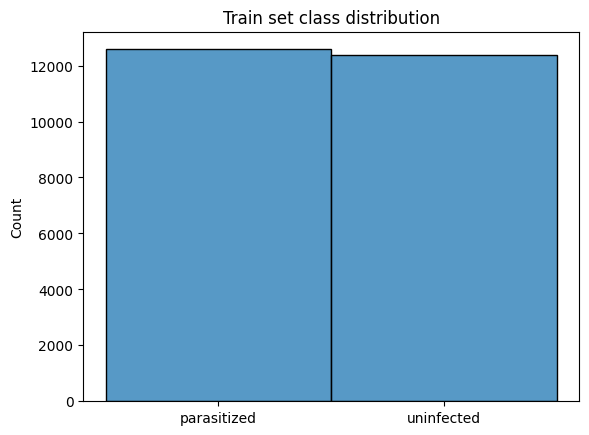

In [23]:
sns.histplot(data=pd.Series(train_labels).map({0:'uninfected', 1: 'parasitized'}))
plt.title('Train set class distribution');

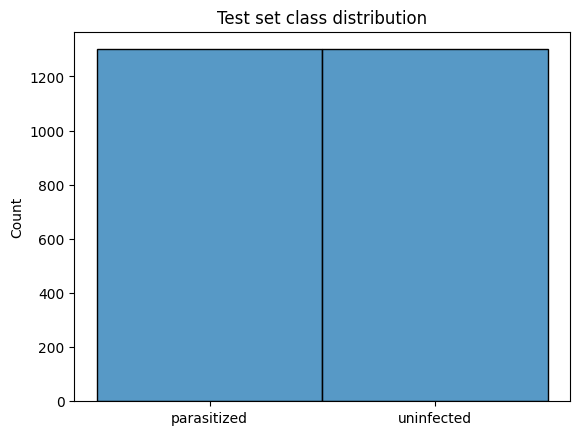

In [24]:
sns.histplot(data=pd.Series(test_labels).map({0:'uninfected', 1: 'parasitized'}))
plt.title('Test set class distribution');


#### <b> Observations and insights: _____ </b>
1. The class labels in both train and test are almost equally distributed.
2. We can say that both the sets are balanced in the outcome variable.

### <b>Data Exploration</b>
Let's visualize the images from the train data

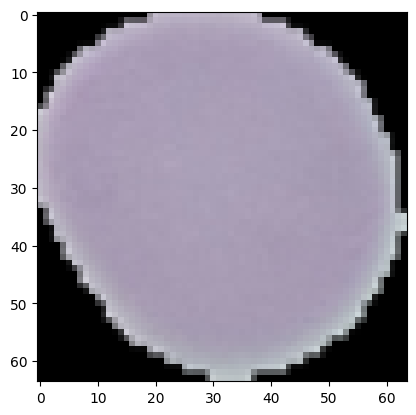

In [25]:
## Uninfected
plt.imshow(train_images_norm[12582]);

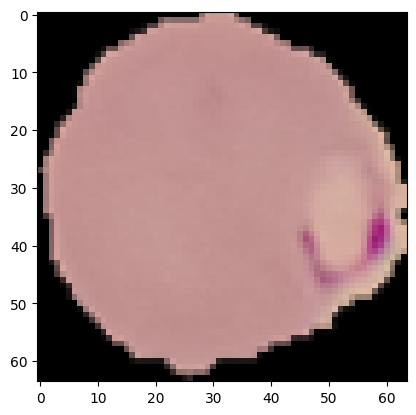

In [26]:
## Parasitized
plt.imshow(train_images_norm[12581]);

#### <b> Observations and insights: _____ </b>
1. All images are 60 x 60 and have 3 channels
2. Because of the way we read the data, all parasitized images are in a sequence, followed by uninfected images. Shuffling may be needed

### <b> Visualize the images with subplot(6, 6) and figsize = (12, 12) </b>

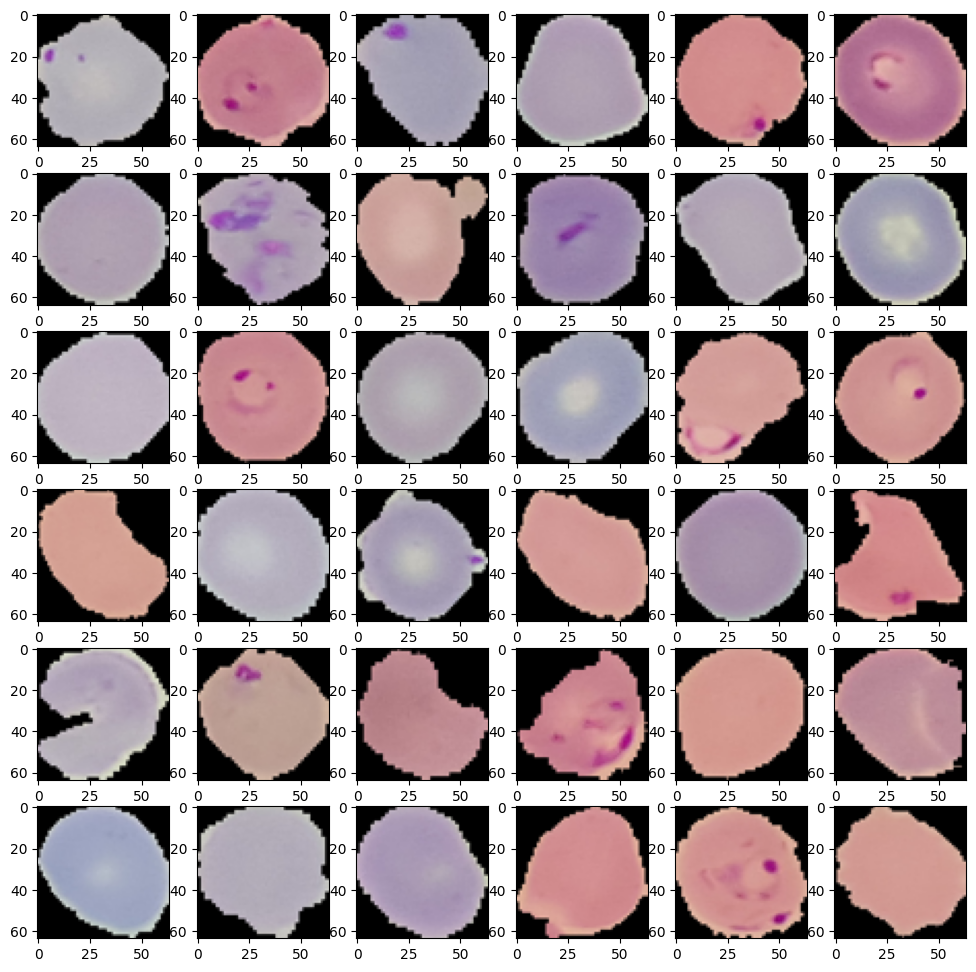

In [27]:
fig, ax = plt.subplots(6, 6, figsize=(12, 12))
ax = ax.flatten()

for i, img in enumerate(np.random.permutation(train_images_norm)[:36]):
    ax[i].imshow(img)

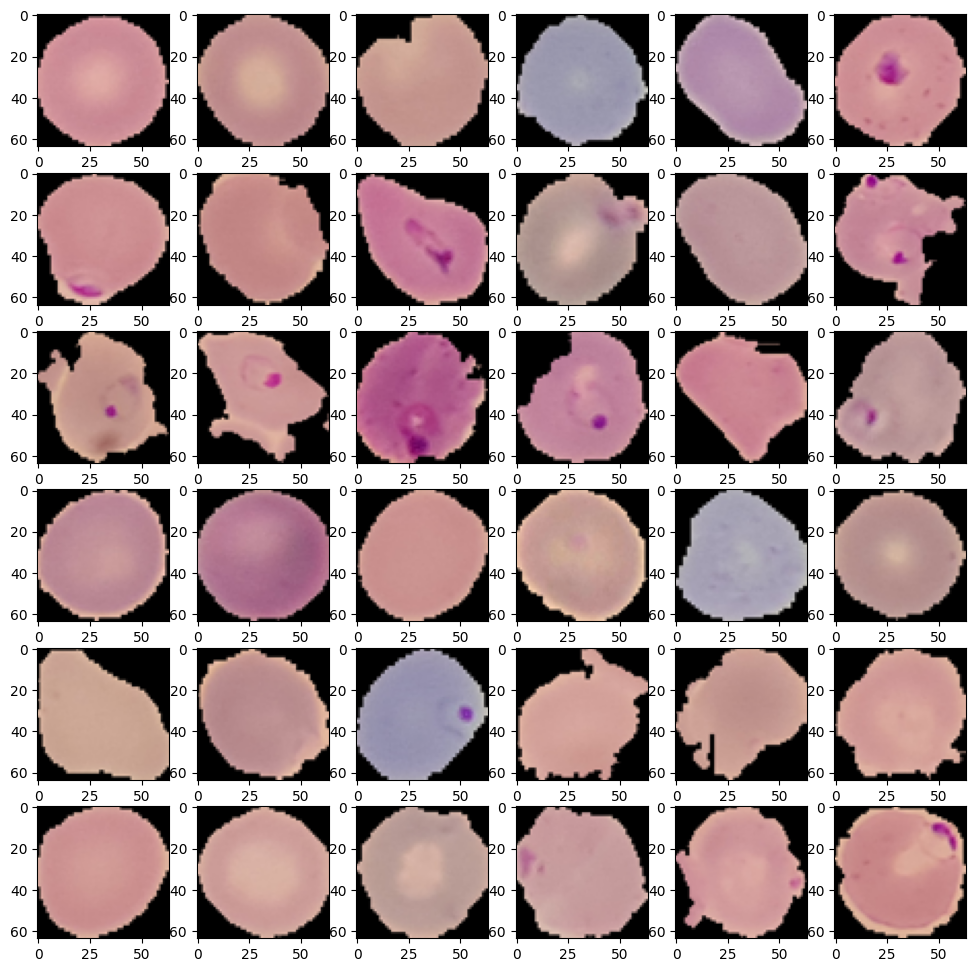

In [28]:
fig, ax = plt.subplots(6, 6, figsize=(12, 12))
ax = ax.flatten()

for i, img in enumerate(np.random.permutation(test_images_norm)[:36]):
    ax[i].imshow(img)

#### <b>Observations and insights: </b>
1. We plotted normalized training and test images

### <b> Plotting the mean images for parasitized and uninfected </b>

In [29]:
train_images_norm_pos = train_images_norm[np.where(train_labels == 1)]
train_images_norm_neg = train_images_norm[np.where(train_labels == 0)]

<b> Mean image for parasitized

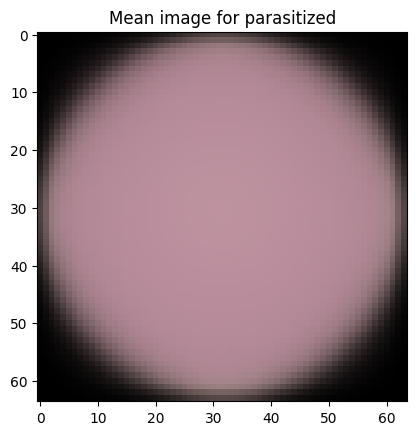

In [30]:
plt.imshow(np.mean(train_images_norm_pos, axis=0))
plt.title('Mean image for parasitized');

<b> Mean image for uninfected

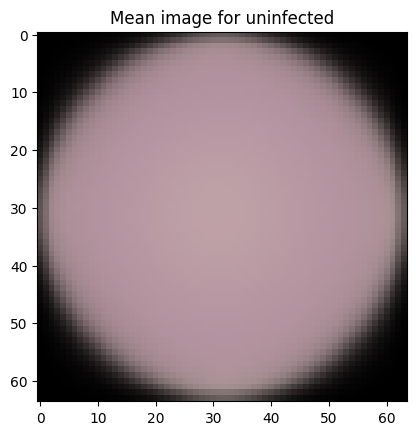

In [31]:
plt.imshow(np.mean(train_images_norm_neg, axis=0))
plt.title('Mean image for uninfected');

##### Vishal's experiment: Does taking SVD of the red channel of the mean of images give us any interesting patterns?

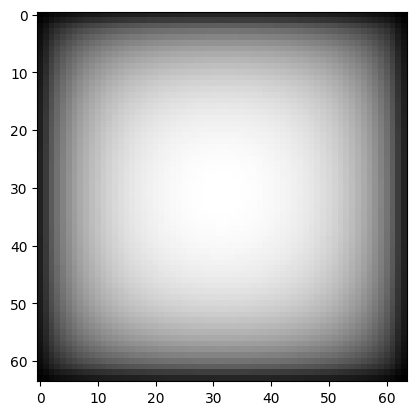

In [32]:
from numpy.linalg import svd

U_r, s_r, V_r = svd(np.mean(train_images_norm_pos[:, :, :, 0], axis=0))
first_singular_vector_U = U_r[:, 0]
first_singular_vector_V = V_r[0, :]
first_singular_value = s_r[0]
#first_singular_value
rank_1_approx = (first_singular_value * np.outer(first_singular_vector_U, first_singular_vector_V))
plt.imshow(rank_1_approx, cmap='gray');


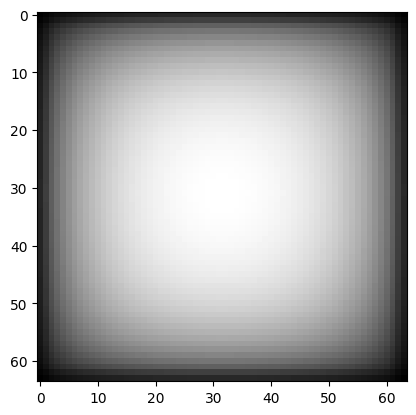

In [33]:
U_r, s_r, V_r = svd(np.mean(train_images_norm_neg[:, :, :, 0], axis=0))
first_singular_vector_U = U_r[:, 0]
first_singular_vector_V = V_r[0, :]
first_singular_value = s_r[0]
#first_singular_value
rank_1_approx = (first_singular_value * np.outer(first_singular_vector_U, first_singular_vector_V))
plt.imshow(rank_1_approx, cmap='gray');

#### <b> Observations and insights: _____ </b>
1. Taking the mean of image classes gives similar results.
2. It could be that the parasitized lines in the positive image class tend to get averaged out over a large sample, and hence the features are blurred out.
3. Taking SVD (one SVD per channel) and plotting the first components of the singular vector of the mean of images doesn't yield any information


### <b>Converting RGB to HSV of Images using OpenCV

### <b> Converting the train data

In [34]:
train_images_norm_hsv = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in train_images_norm])

 ### <b> Converting the test data

In [35]:
test_images_norm_hsv = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in test_images_norm])

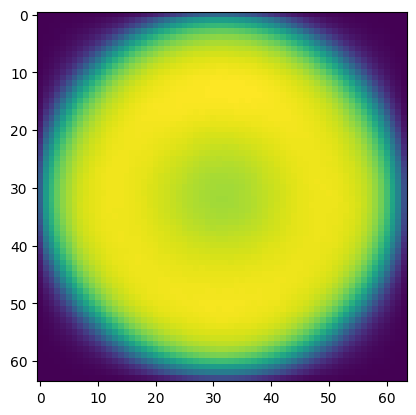

In [36]:
# Plot the mean of the Hue channel
plt.imshow(np.mean(train_images_norm_hsv[:,:,:,0], axis=0));

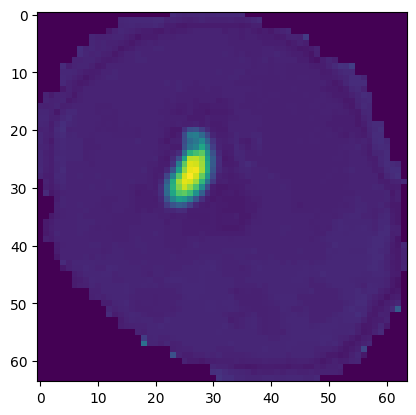

In [37]:
# Plot the Saturation channel for a single image
plt.imshow(train_images_norm_hsv[0,:,:,1]);

#### Check the mean color intensities in pos and neg images

In [38]:
train_images_norm_hsv_pos = train_images_norm_hsv[np.where(train_labels == 1)]
train_images_norm_hsv_neg = train_images_norm_hsv[np.where(train_labels == 0)]

In [39]:
print('Mean Hue of parasitized images', np.mean(train_images_norm_hsv_pos[:,:,:,0]))
print('Mean Hue of uninfected images', np.mean(train_images_norm_hsv_neg[:,:,:,0]))

Mean Hue of parasitized images 162.43643
Mean Hue of uninfected images 141.36684


In [40]:
print('Mean Saturation of parasitized images', np.mean(train_images_norm_hsv_pos[:,:,:,1]))
print('Mean Saturation of uninfected images', np.mean(train_images_norm_hsv_neg[:,:,:,1]))

Mean Saturation of parasitized images 0.1887079
Mean Saturation of uninfected images 0.14826767


In [41]:
print('Mean Brightness of parasitized images', np.mean(train_images_norm_hsv_pos[:,:,:,2]))
print('Mean Brightness of uninfected images', np.mean(train_images_norm_hsv_neg[:,:,:,2]))

Mean Brightness of parasitized images 0.54425305
Mean Brightness of uninfected images 0.5470635


#### <b>Observations and insights: _____ </b>

1. There seems to be a difference between hue and saturation values of parasitized vs uninfected images. Brightness values for both image classes is similar.
    - Mean Hue of parasitized images 162.43
    - Mean Hue of uninfected images 141.36
    - Mean Saturation of parasitized images 0.188
    - Mean Saturation of uninfected images 0.148
    - Mean Brightness of parasitized images 0.544
    - Mean Brightness of uninfected images 0.547

2. HSV has three channels: Hue (0-360 degrees), Saturation (0-1), Value for brightness (0-1)
3. HSV images can't be plotted directly using imshow() because the function expects RGB values


### Try pre-processing by converting RGB to LAB (Luminosity, Red-Green, Yellow-Blue)

In [42]:
train_images_norm_lab = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in train_images_norm])
test_images_norm_lab = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in test_images_norm])

##### Visualize the L chanel of the first image

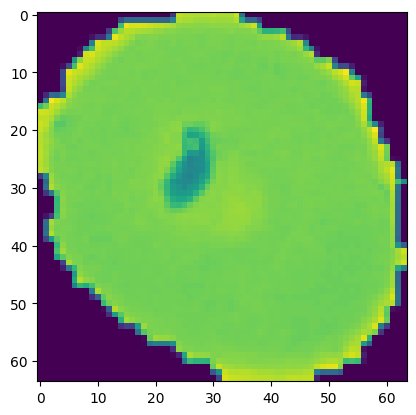

In [43]:
plt.imshow(train_images_norm_lab[0,:,:,0])

#### Try adaptive histogram equalization on the L channel
- A technique used to enhance contrast in images with low contrast or uneven illumination

In [44]:
# Load the first image into a temp variable
temp_img = train_images_norm_lab[0, :, :, :]

In [45]:
# Split into three channels and convert the L channel to uint8
l, a, b = np.array(cv2.split(temp_img))
l = np.uint8(l)

In [46]:
# Apply the Contrast Limited Adaptive Hitogram Equalization technique
clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(2,2))
cl = clahe.apply(l)
cl = np.float32(cl)
temp_img = cv2.merge((cl, a, b))

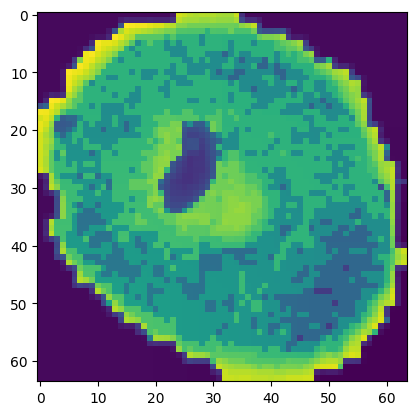

In [47]:
## Visualize the L channel of the first image after contrast enhancement
plt.imshow(temp_img[:,:,0])

##### Observation:
1. It looks like applying the histogram equalization technique on the L channel of the LAB color-scheme enhances the contrast
2. However, to keep things simple, we might want to apply the contrast enhancement techniques to RGB space

#### Try applying CLAHE (Contrast Limited Adaptive Histogram Equalization) to a single RGB images

In [48]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))

In [49]:
temp_image = train_images[110]

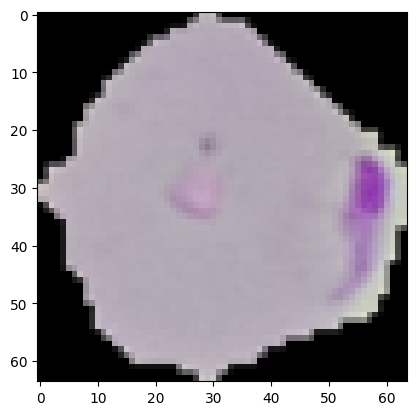

In [50]:
plt.imshow(temp_image)

In [51]:
r, g, b = np.uint8(cv2.split(temp_image))

In [52]:
r_processed = clahe.apply(r)
g_processed = clahe.apply(g)
b_processed = clahe.apply(b)

In [53]:
temp_image_processed = cv2.merge([r_processed, g_processed, b_processed])

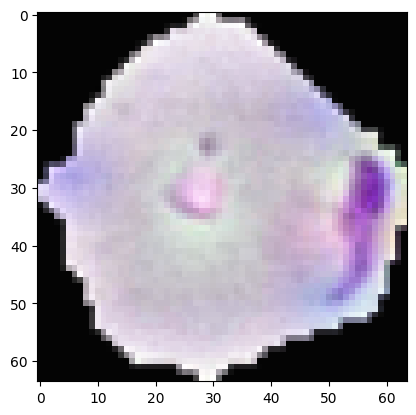

In [54]:
## Plot the processed image with enhanced contrast
plt.imshow(temp_image_processed);

In [55]:
def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    processed_images = []

    for img in images:
        r, g, b = np.uint8(cv2.split(img))
        r_processed = clahe.apply(r)
        g_processed = clahe.apply(g)
        b_processed = clahe.apply(b)

        tmp_img= ((cv2.merge([r_processed, g_processed, b_processed])))
        processed_images.append(tmp_img)
    return np.array(processed_images)

In [56]:
# Create contrast-enhanced train and test sets
train_images_clahe = apply_clahe(train_images)
test_images_clahe = apply_clahe(test_images)

In [57]:
# Normalize
train_images_clahe_norm = train_images_clahe / 255.0
test_images_clahe_norm = test_images_clahe / 255.0

##### Observations:
1. Applying contrast enhancement to all 3 RGB channels seems to enhance the boundary of the plasmodium parasite which is very red/pink in color compared to the cytoplasm of the cell. This may be a useful feature in training

### <b> Processing Images using Gaussian Blurring

### <b> Gaussian Blurring on train data

In [58]:
train_images_norm_blur = np.array([cv2.GaussianBlur(img, (5,5), sigmaX=0) for img in train_images_norm])

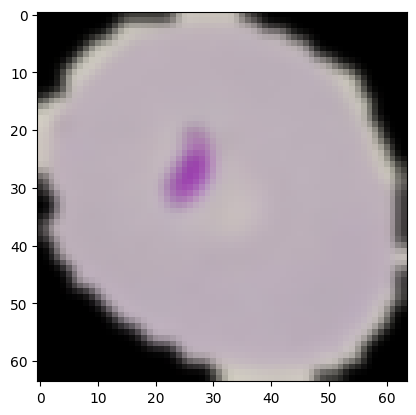

In [59]:
plt.imshow(train_images_norm_blur[0]);

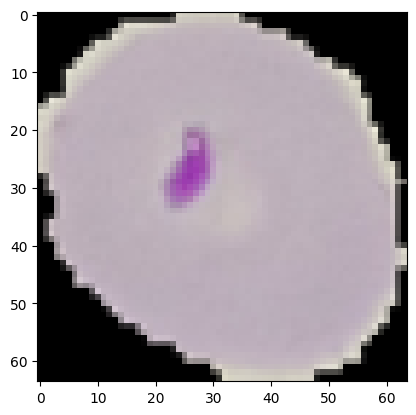

In [60]:
plt.imshow(train_images_norm[0]);

### <b> Gaussian Blurring on test data

In [61]:
test_images_norm_blur = np.array([cv2.GaussianBlur(img, (5,5), sigmaX=0) for img in test_images_norm])

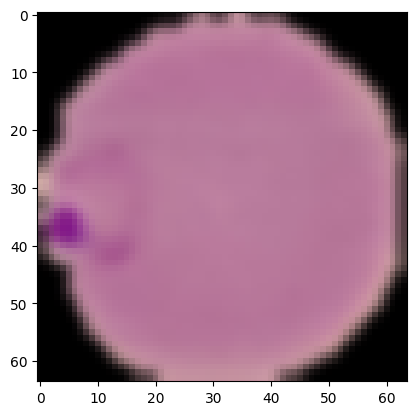

In [62]:
plt.imshow(test_images_norm_blur[0]);

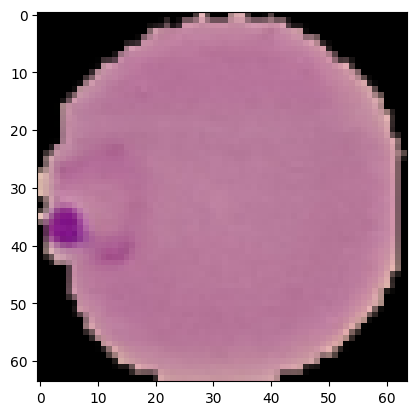

In [63]:
plt.imshow(test_images_norm[0]);

#### **Observations and insights: _____**

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

1. Visually, it seems that the parasite is defined by its boundary and its deep-purple color in the images.
2. The cytoplasm itself can be pink and sometimes blue in these images.
3. As seen above, blurring causes the edges of the plasmodium parasite to blend with the background (cytoplasm). Blurring adds noise to the images, and the model may have a hard time detecting edges and outline of the parasite.
4. What we can try is methods that enhance these boundaries and edges, such as contrast enhancement techniques.

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

### <b> Importing the required libraries for building and training our Model

In [132]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, ReLU, LeakyReLU, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [65]:
backend.clear_session()

import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

####<B>One Hot Encoding the train and test labels

In [66]:
train_labels_encoded = to_categorical(train_labels, num_classes=2)
test_labels_encoded = to_categorical(test_labels, num_classes=2)

###<b> Building the base models with HSV transformation applied

In [67]:
## Get the size of the training and test set images to know the number of input neurons

print('Train image shape: ', train_images_norm_hsv.shape)
print('Total input layers needed: ', 64*64*3)


Train image shape:  (24958, 64, 64, 3)
Total input layers needed:  12288


In [68]:
## Reshape the input
train_images_norm_hsv_flatten = train_images_norm_hsv.reshape(train_images_norm_hsv.shape[0], -1)
test_images_norm_hsv_flatten = test_images_norm_hsv.reshape(test_images_norm_hsv.shape[0], -1)
print('Train images shape: ', train_images_norm_hsv_flatten.shape)
print('Test images shape: ', test_images_norm_hsv_flatten.shape)

Train images shape:  (24958, 12288)
Test images shape:  (2600, 12288)


In [69]:
## Build a fully connected ANN model

model = Sequential()

model.add(Dense(units=64, activation='relu', input_shape=(12288,)))

model.add(Dense(units=32, activation='relu'))

model.add(Dense(units=2, activation='softmax'))

In [70]:
## second base model

model2 = Sequential()

model2.add(Dense(units=128, activation='relu', input_shape=(12288,)))
model2.add(Dropout(0.2))
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(units=32, activation='relu'))
#model2.add(Dropout(0.2))
model2.add(Dense(units=2, activation='softmax'))

###<b> Compiling the model

In [71]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       786,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 788,642 (3.01 MB)

 Trainable params: 788,642 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,583,394 (6.04 MB)

 Trainable params: 1,583,394 (6.04 MB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks

In [75]:
## implement early stop and Reduce LR on Plateau
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True, #don't return just the most recent weights, return the best one so far.
    min_delta=0.005, # min change to qualify as improvement
    mode='auto',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    mode='auto'
)

<b> Fit and train our Model

In [76]:
history_base_model_1 = model.fit(x=train_images_norm_hsv_flatten,
                                 y=train_labels_encoded, validation_split=0.2,
                                 batch_size=128,
                                 epochs=30,
                                 verbose=1,
                                 shuffle=True, callbacks=[early_stop, reduce_lr])

Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5789 - loss: 40.3473 - val_accuracy: 0.7286 - val_loss: 2.8938 - learning_rate: 0.0010
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6175 - loss: 5.5800 - val_accuracy: 0.1903 - val_loss: 8.7157 - learning_rate: 0.0010
Epoch 3/30
143/156 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6425 - loss: 3.1415
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6424 - loss: 3.2040 - val_accuracy: 0.5994 - val_loss: 3.8360 - learning_rate: 0.0010
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6566 - loss: 2.2378 - val_accuracy: 0.7939 - val_loss: 0.8060 - learning_rate: 5.0000e-04
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6688 - loss: 1.3631 - val_accuracy: 0.2268 - val_loss: 8.1224 - learning_rate: 5.0000e-04
Epoch 6/30
153/156 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6644 - loss: 

In [77]:
history_base_model_2 = model2.fit(x=train_images_norm_hsv_flatten,
                                 y=train_labels_encoded, validation_split=0.2,
                                 batch_size=128,
                                 epochs=30,
                                 verbose=1,
                                 shuffle=True,
                                  callbacks=[early_stop, reduce_lr])

Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5655 - loss: 45.9512 - val_accuracy: 0.0016 - val_loss: 0.9943 - learning_rate: 0.0010
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6253 - loss: 0.6976 - val_accuracy: 6.0096e-04 - val_loss: 1.0046 - learning_rate: 0.0010
Epoch 3/30
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6276 - loss: 0.6692
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6276 - loss: 0.6691 - val_accuracy: 8.0128e-04 - val_loss: 0.9990 - learning_rate: 0.0010
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6281 - loss: 0.6694 - val_accuracy: 6.0096e-04 - val_loss: 1.0021 - learning_rate: 5.0000e-04
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6337 - loss: 0.6565 - val_accuracy: 0.0020 - val_loss: 0.9902 - learning_rate: 5.0000e-04
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6

###<b> Evaluating the model on test data

In [78]:
## Evaluate base model 1
model.evaluate(test_images_norm_hsv_flatten, test_labels_encoded, verbose=2)

82/82 - 1s - 17ms/step - accuracy: 0.6212 - loss: 1.5497


[1.5496829748153687, 0.6211538314819336]

In [79]:
## Evaluate base model 2
model2.evaluate(test_images_norm_hsv_flatten, test_labels_encoded, verbose=2)

82/82 - 2s - 24ms/step - accuracy: 0.6154 - loss: 0.6611


[0.6610875725746155, 0.6153846383094788]

In [80]:
## Test how a prediction with base model 1 looks like
np.argmax(model.predict(test_images_norm_hsv_flatten)[2462])

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


np.int64(1)

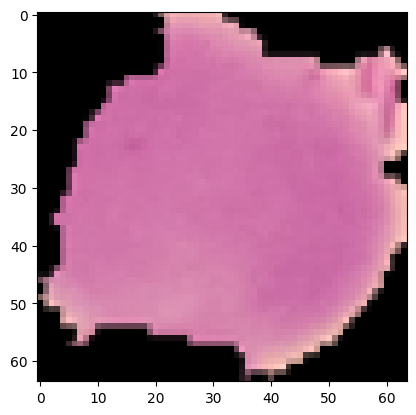

In [81]:
## Clearly this is not infected -- misclassified
plt.imshow(test_images_norm[2462]);

<b> Plotting the confusion matrix

In [82]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [83]:
def plot_confusion_matrix(model, x_test, y_test, use_pct=False):
  pred = model.predict(x=x_test)
  pred = np.argmax(pred, axis=1)
  true = np.argmax(y_test, axis=1)

  cm = confusion_matrix(true, pred)
  cm_pct = cm.astype('float')/cm.sum(axis=1).reshape(2,1)
  plt.figure(figsize=(6,6))
  if use_pct == True:
    sns.heatmap(cm, annot=cm_pct, fmt='.2f', xticklabels=['uninfected', 'parasitized'], yticklabels=['uninfected', 'parasitized'])
  else:
    sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=['uninfected', 'parasitized'], yticklabels=['uninfected', 'parasitized'])

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


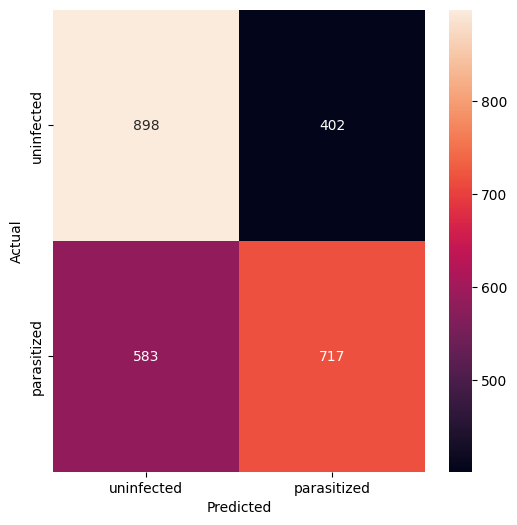

In [84]:
## For base model 1
plot_confusion_matrix(model, test_images_norm_hsv_flatten, test_labels_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


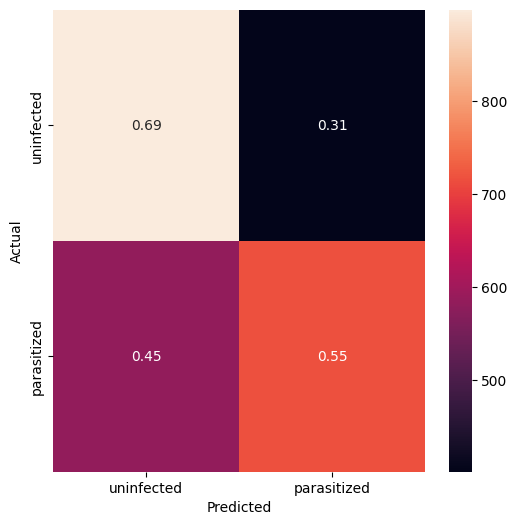

In [85]:
plot_confusion_matrix(model, test_images_norm_hsv_flatten, test_labels_encoded, use_pct=True)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


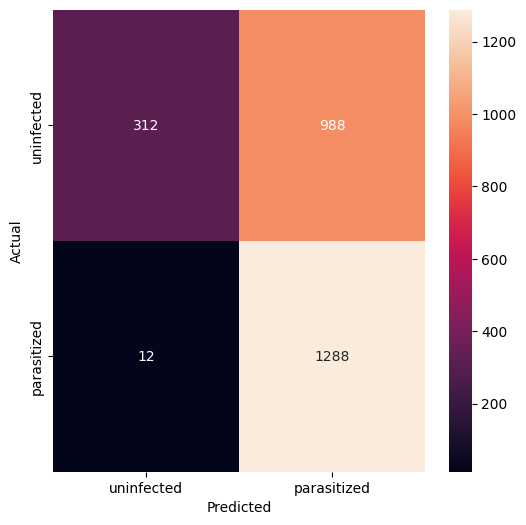

In [86]:
## Plot confusion matrix for model 2
plot_confusion_matrix(model2, test_images_norm_hsv_flatten, test_labels_encoded)

<b>Plotting the train and validation curves

In [87]:
def plot_model_accuracy(model_history, title='Model Accuracy', plot_params={'accuracy': 'training_accuracy', 'val_accuracy': 'validation_accuracy', 'loss': 'training_loss'}):
  for param, param_name in plot_params.items():
    sns.lineplot(model_history.history[param], label = param_name)

  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show();

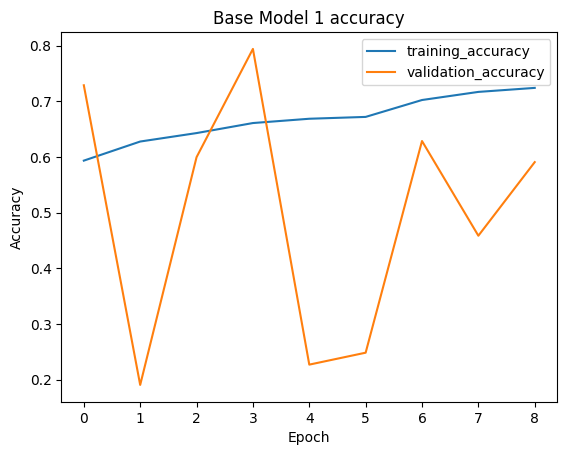

In [88]:
plot_model_accuracy(history_base_model_1, title='Base Model 1 accuracy', plot_params={'accuracy':'training_accuracy', 'val_accuracy': 'validation_accuracy'})

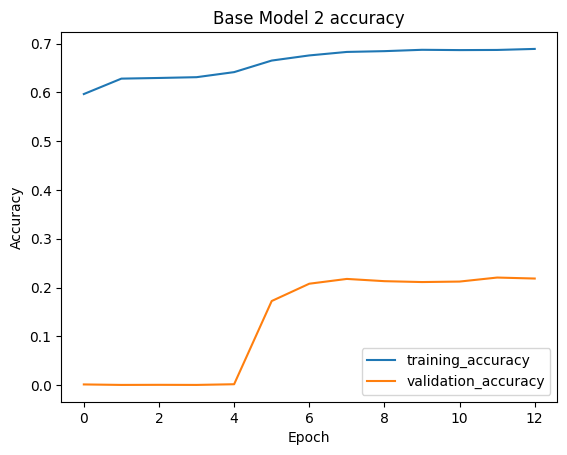

In [89]:
plot_model_accuracy(history_base_model_2, title='Base Model 2 accuracy', plot_params={'accuracy':'training_accuracy', 'val_accuracy': 'validation_accuracy'})

### Building the base model with CLAHE pre-processing

In [90]:
backend.clear_session()

In [91]:
## Check the input shape

print('Train image shape: ', train_images_clahe_norm.shape)

Train image shape:  (24958, 64, 64, 3)


In [92]:
## Build the third base model but this time with input shape (64, 64, 3)
model3 = Sequential()

model3.add(Flatten(input_shape=(64,64,3)))
model3.add(Dense(units=64, activation='relu'))

model3.add(Dense(units=32, activation='relu'))

model3.add(Dense(units=2, activation='softmax'))

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       786,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 788,642 (3.01 MB)

 Trainable params: 788,642 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
## compile model3
# learning rate controls the magnitude of all paramter updates. The learning rates are updated for each parameter
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
## fit the base model3
history_base_model_3 = model3.fit(x=train_images_clahe_norm, y=train_labels_encoded,
                                  validation_split=0.2, batch_size=128, epochs=50, verbose=1, shuffle=True,
                                  callbacks=[early_stop, reduce_lr])

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5847 - loss: 1.2543 - val_accuracy: 0.2973 - val_loss: 0.8801 - learning_rate: 0.0010
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6572 - loss: 0.6329 - val_accuracy: 0.1026 - val_loss: 1.2192 - learning_rate: 0.0010
Epoch 3/50
154/156 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6559 - loss: 0.6319
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6562 - loss: 0.6316 - val_accuracy: 0.1326 - val_loss: 1.2066 - learning_rate: 0.0010
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6751 - loss: 0.6138 - val_accuracy: 0.3936 - val_loss: 0.8805 - learning_rate: 5.0000e-04
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6767 - loss: 0.6062 - val_accuracy: 0.4287 - val_loss: 0.8583 - learning_rate: 5.0000e-04
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6792 - loss: 0

In [95]:
## Evaluate model3 on test set

model3.evaluate(test_images_clahe_norm, test_labels_encoded, verbose=1)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7279 - loss: 0.5567


[0.6568014025688171, 0.6265384554862976]

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


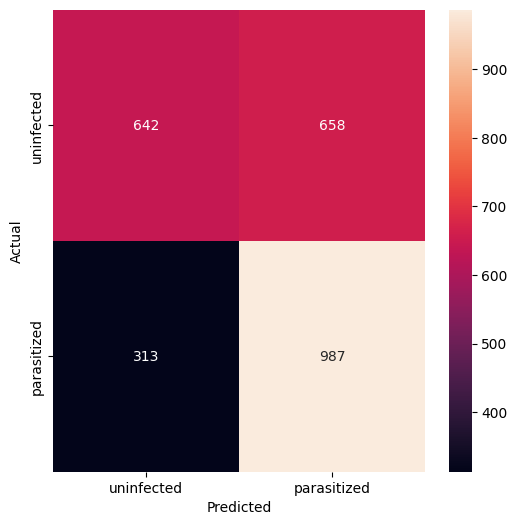

In [96]:
## plot the confusion matrix

plot_confusion_matrix(model3, test_images_clahe_norm, test_labels_encoded)

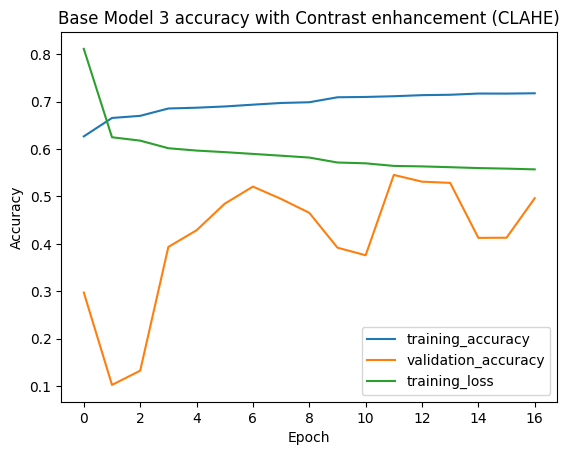

In [97]:
## Plot model3 loss, accuracy, and validation accuracy
plot_model_accuracy(history_base_model_3, title='Base Model 3 accuracy with Contrast enhancement (CLAHE)')

#### Observations:



1. On checking the performance on validation set, the contrast enhanced image does slightly better with 0.65 accuracy vs 0.64 for HSV pre-processed image trained on the same Neural Network architecture. However, the contrast-enhanced data has more stable validation accuracy, probably because there are more definite features to capture?

2. So overall I have higher accuracy on test set than on my validation split during training. Maybe because test set is only 10% of the training set?
3. Simple ANN seems to work better than deeper and more complex ANN model with dropout, especially on the validation accuracy

### End Base model explorations

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


###<b> Building the Model

In [103]:
## Build a CNN model

model_cnn = Sequential(
    [
        Conv2D(filters=64, kernel_size=(2,2), input_shape=(64,64,3), padding='same'),
        ReLU(),
        MaxPooling2D((2,2), padding='same'), # the purpose of padding here is to ensure that kernel size isn't out of bounds when input size is not an integer multiple of kernel size. https://datascience.stackexchange.com/questions/67334/whats-the-purpose-of-padding-with-maxpooling

        Conv2D(filters=32, kernel_size=(2,2), padding='same'),
        ReLU(),
        MaxPooling2D((2,2), padding='same'),
        # Flatten the input for ANN
        Flatten(),
        # Fully connected layer
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')

    ]
)


###<b> Compiling the model

In [104]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,538 (2.04 MB)

 Trainable params: 533,538 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks

In [105]:
## implement early stop and Reduce LR on Plateau
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True, #don't return just the most recent weights, return the best one so far.
    min_delta=0.005, # min change to qualify as improvement
    mode='auto',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    mode='auto'
)

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Data Science/MIT Bootcamp/cell_image_task_checkpoints/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.keras',
    monitor='val_accuracy',
    verbose=2,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

<b>Fit and Train the model

In [106]:
history_cnn_model_1 = model_cnn.fit(train_images_clahe_norm, train_labels_encoded, validation_split=0.2, epochs=20, verbose=1, shuffle=True, batch_size=32,
                                    callbacks=[reduce_lr, early_stop, checkpoint_callback])

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6473 - loss: 0.6381
Epoch 1: val_accuracy improved from -inf to 0.92167, saving model to /content/drive/MyDrive/Data Science/MIT Bootcamp/cell_image_task_checkpoints/model_epoch_01_val_accuracy_0.92.keras
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6473 - loss: 0.6380 - val_accuracy: 0.9217 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 2/20
618/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9012 - loss: 0.2910
Epoch 2: val_accuracy improved from 0.92167 to 0.98237, saving model to /content/drive/MyDrive/Data Science/MIT Bootcamp/cell_image_task_checkpoints/model_epoch_02_val_accuracy_0.98.keras
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9015 - loss: 0.2901 - val_accuracy: 0.9824 - val_loss: 0.1359 - learning_rate: 0.0010
Epoch 3/20
612/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9566 - loss: 0.1330
Epoch 3: val_accuracy improved from 0.98237 to 0.98718, saving model to /content/drive/

In [107]:
## load the saved model
#tf.keras.models.load_model('model_path.keras')

###<b> Evaluating the model

In [108]:
model_cnn.evaluate(test_images_clahe_norm, test_labels_encoded, verbose=2)

82/82 - 1s - 14ms/step - accuracy: 0.9585 - loss: 0.1624


[0.1623963862657547, 0.9584615230560303]

<b> Plotting the confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


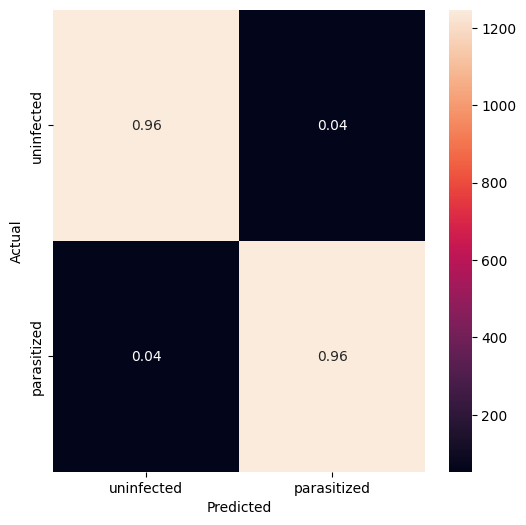

In [109]:
plot_confusion_matrix(model_cnn, test_images_clahe_norm, test_labels_encoded, use_pct=True)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


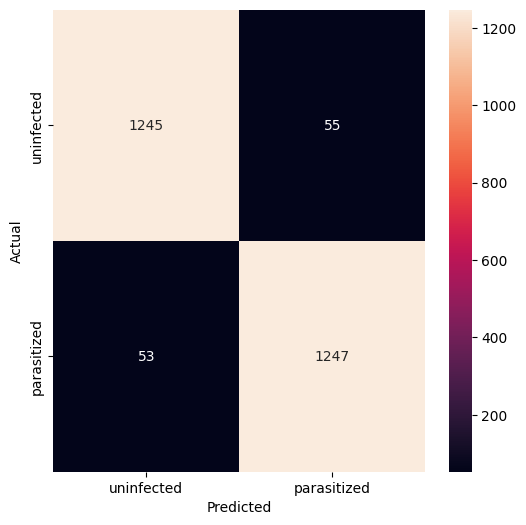

In [110]:
plot_confusion_matrix(model_cnn, test_images_clahe_norm, test_labels_encoded)

<b> Plotting the train and the validation curves

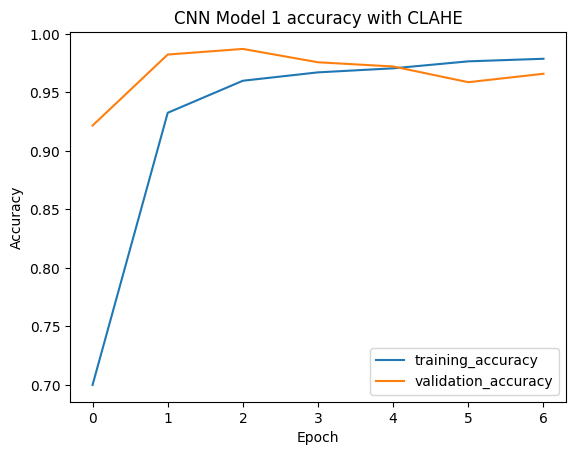

In [111]:
plot_model_accuracy(history_cnn_model_1, title='CNN Model 1 accuracy with CLAHE', plot_params={'accuracy':'training_accuracy', 'val_accuracy': 'validation_accuracy'})

### Try training on HSV files

In [112]:
backend.clear_session()

## Build a CNN model

model_cnn = Sequential(
    [
        Conv2D(filters=64, kernel_size=(2,2), input_shape=(64,64,3), padding='same'),
        ReLU(),
        MaxPooling2D((2,2), padding='same'), # the purpose of padding here is to ensure that kernel size isn't out of bounds when input size is not an integer multiple of kernel size. https://datascience.stackexchange.com/questions/67334/whats-the-purpose-of-padding-with-maxpooling

        Conv2D(filters=32, kernel_size=(2,2), padding='same'),
        ReLU(),
        MaxPooling2D((2,2), padding='same'),
        # Flatten the input for ANN
        Flatten(),
        # Fully connected layer
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')

    ]
)

# Compile
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,538 (2.04 MB)

 Trainable params: 533,538 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [113]:
history_cnn_model_1_hsv = model_cnn.fit(train_images_norm_hsv, train_labels_encoded, validation_split=0.2, epochs=20, verbose=1, shuffle=True, batch_size=32,
                                    callbacks=[reduce_lr, early_stop, checkpoint_callback])

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6483 - loss: 4.9823
Epoch 1: val_accuracy did not improve from 0.98718
624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6484 - loss: 4.9766 - val_accuracy: 0.4028 - val_loss: 0.8410 - learning_rate: 0.0010
Epoch 2/20
611/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7266 - loss: 0.5322
Epoch 2: val_accuracy did not improve from 0.98718
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7268 - loss: 0.5319 - val_accuracy: 0.4764 - val_loss: 0.8283 - learning_rate: 0.0010
Epoch 3/20
608/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7543 - loss: 0.4811
Epoch 3: val_accuracy did not improve from 0.98718
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7545 - loss: 0.4808 - val_accuracy: 0.4828 - val_loss: 0.8976 - learning_rate: 0.0010
Epoch 4/20
619/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7886 - loss: 0.4290
Epoch 4: val_accuracy did not improve from 0.98718
624/624 ━━━━━━━━━━━━━━━━━━━━ 

In [114]:
model_cnn.evaluate(test_images_norm_hsv, test_labels_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8112 - loss: 0.5052


[0.843764066696167, 0.7073076963424683]

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


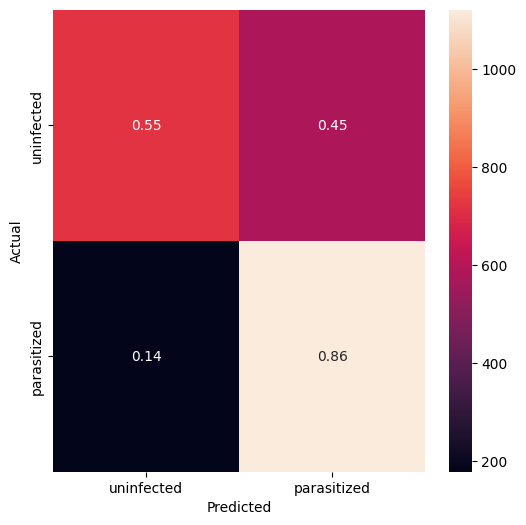

In [115]:
plot_confusion_matrix(model_cnn, test_images_norm_hsv, test_labels_encoded, use_pct=True)

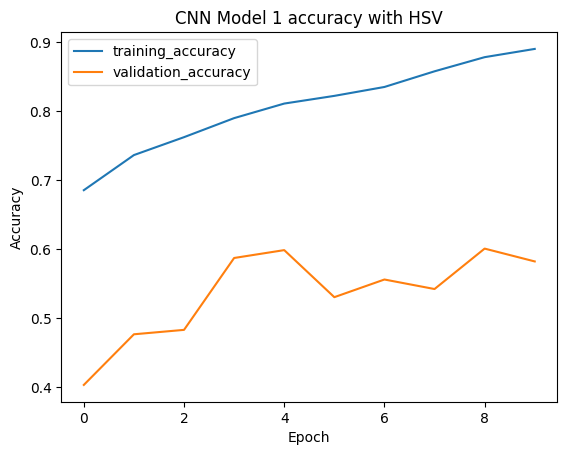

In [116]:
plot_model_accuracy(history_cnn_model_1_hsv, title='CNN Model 1 accuracy with HSV', plot_params={'accuracy':'training_accuracy', 'val_accuracy': 'validation_accuracy'})

##### Build another CNN model with He initialization
- He uniform initialization helps initialize weights allows faster convergence, reduced vanishing/exploding gradients, and gives better performance with ReLU. The variance of weights are initialized as 2/fan_in where fan_in = the number of inputs to a neuron.
- The min and max limit for initialization is calculated as SQRT(6/fan_in)

In [117]:
backend.clear_session()

## Build a CNN model

model_cnn = Sequential(
    [
        Conv2D(filters=64, kernel_size=(2,2), input_shape=(64,64,3), padding='same', kernel_initializer='he_uniform'),
        ReLU(),
        MaxPooling2D((2,2), padding='same'), # the purpose of padding here is to ensure that kernel size isn't out of bounds when input size is not an integer multiple of kernel size. https://datascience.stackexchange.com/questions/67334/whats-the-purpose-of-padding-with-maxpooling

        Conv2D(filters=32, kernel_size=(2,2), padding='same', kernel_initializer='he_uniform'),
        ReLU(),
        MaxPooling2D((2,2), padding='same'),
        # Flatten the input for ANN
        Flatten(),
        # Fully connected layer
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')

    ]
)

# Compile
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,538 (2.04 MB)

 Trainable params: 533,538 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
history_cnn_model_2_hsv = model_cnn.fit(train_images_norm_hsv, train_labels_encoded, validation_split=0.2, epochs=20, verbose=1, batch_size=32,
              callbacks=[reduce_lr, early_stop], shuffle=True)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6178 - loss: 38.4198 - val_accuracy: 0.2376 - val_loss: 0.8088 - learning_rate: 0.0010
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7048 - loss: 0.5467 - val_accuracy: 0.4690 - val_loss: 0.7396 - learning_rate: 0.0010
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7332 - loss: 0.5039 - val_accuracy: 0.4583 - val_loss: 0.8386 - learning_rate: 0.0010
Epoch 4/20
618/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7526 - loss: 0.4697
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7526 - loss: 0.4697 - val_accuracy: 0.4042 - val_loss: 0.9227 - learning_rate: 0.0010
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7684 - loss: 0.4385 - val_accuracy: 0.3592 - val_loss: 1.0201 - learning_rate: 5.0000e-04
Epoch 6/20
618/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7811 - loss: 0.408

In [119]:
model_cnn.evaluate(test_images_norm_hsv, test_labels_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8132 - loss: 0.4996


[0.6406740546226501, 0.6596153974533081]

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


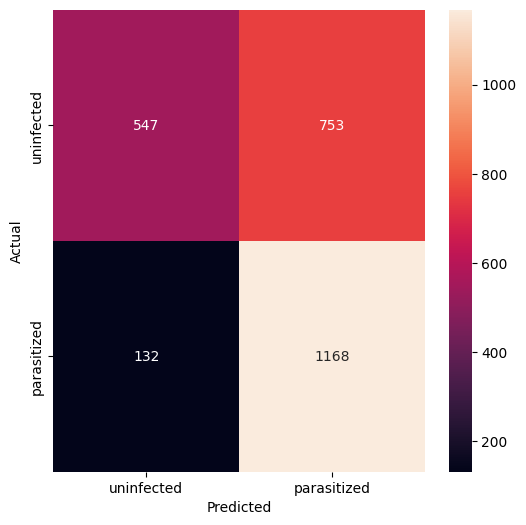

In [120]:
plot_confusion_matrix(model_cnn, test_images_norm_hsv, test_labels_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


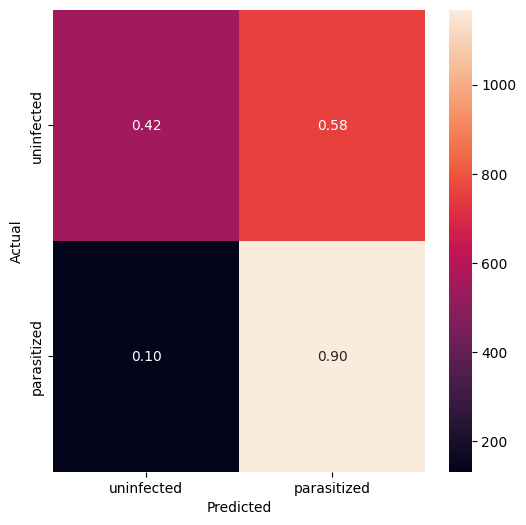

In [121]:
plot_confusion_matrix(model_cnn, test_images_norm_hsv, test_labels_encoded, use_pct=True)

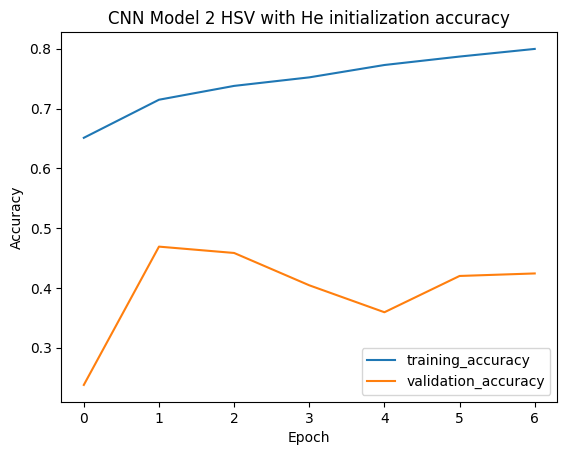

In [122]:
plot_model_accuracy(history_cnn_model_2_hsv, title='CNN Model 2 HSV with He initialization accuracy', plot_params={'accuracy':'training_accuracy', 'val_accuracy': 'validation_accuracy'})

##### Try the He initialization model with unprocessed images

In [123]:
backend.clear_session()

## Build a CNN model

model_cnn = Sequential(
    [
        Conv2D(filters=64, kernel_size=(2,2), input_shape=(64,64,3), padding='same', kernel_initializer='he_uniform'),
        ReLU(),
        MaxPooling2D((2,2), padding='same'), # the purpose of padding here is to ensure that kernel size isn't out of bounds when input size is not an integer multiple of kernel size. https://datascience.stackexchange.com/questions/67334/whats-the-purpose-of-padding-with-maxpooling

        Conv2D(filters=32, kernel_size=(2,2), padding='same', kernel_initializer='he_uniform'),
        ReLU(),
        MaxPooling2D((2,2), padding='same'),
        # Flatten the input for ANN
        Flatten(),
        # Fully connected layer
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')

    ]
)

# Compile
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,538 (2.04 MB)

 Trainable params: 533,538 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
history_cnn_model_2_raw = model_cnn.fit(train_images_norm, train_labels_encoded, validation_split=0.2, epochs=20, verbose=1, batch_size=32,
              callbacks=[reduce_lr, early_stop], shuffle=True)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7141 - loss: 0.6169 - val_accuracy: 0.8109 - val_loss: 0.3763 - learning_rate: 0.0010
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9167 - loss: 0.2281 - val_accuracy: 0.8323 - val_loss: 0.2339 - learning_rate: 0.0010
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9312 - loss: 0.1595 - val_accuracy: 0.9353 - val_loss: 0.1404 - learning_rate: 0.0010
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9455 - loss: 0.1333 - val_accuracy: 0.9501 - val_loss: 0.1337 - learning_rate: 0.0010
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9582 - loss: 0.1173 - val_accuracy: 0.9716 - val_loss: 0.1004 - learning_rate: 0.0010
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9645 - loss: 0.0998 - val_accuracy: 0.9734 - val_loss: 0.1002 - learning_rate: 0.0010
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9689 - loss: 0.0903 - 

In [125]:
model_cnn.evaluate(test_images_norm, test_labels_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9713 - loss: 0.0959


[0.15618659555912018, 0.9526923298835754]

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


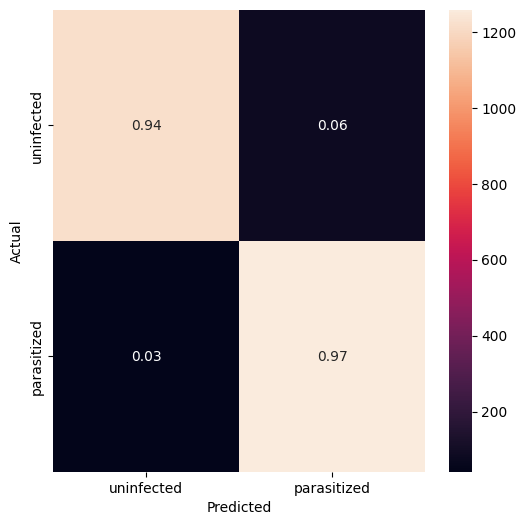

In [126]:
plot_confusion_matrix(model_cnn, test_images_norm, test_labels_encoded, use_pct=True)

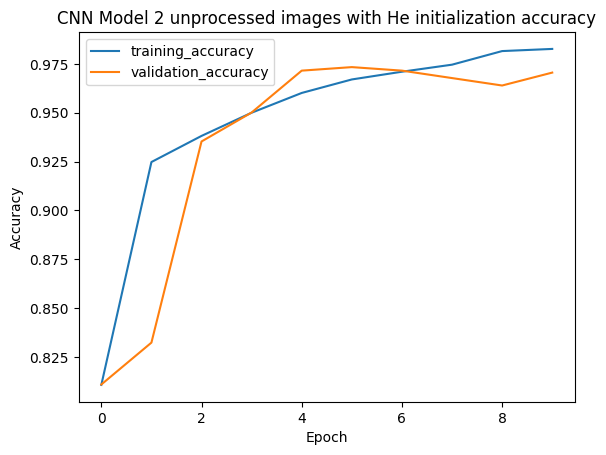

In [127]:
plot_model_accuracy(history_cnn_model_2_raw, title='CNN Model 2 unprocessed images with He initialization accuracy', plot_params={'accuracy':'training_accuracy', 'val_accuracy': 'validation_accuracy'})

##### Observations:
1. The validation accuracy on the same model trained with CLAHE is must better! Performing convolutions on CLAHE images vs HSV gave us significantly higher accuracy and a stable validation accuracy over epochs.
2. Training with raw unprocessed images surprisingly gave as good of results as contrast enhancement. ALthough with CLHAE we get 2% False Negative vs 3% with raw images, and with CLHAE we get 5% False Positives vs 4% with raw images.
3. I assumed doing backend.clear_session() would allow me to recompile the model and fit on new data. Apparently that's not the case, the model object must be re-created every time you wish to fit new data

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [128]:
backend.clear_session()

###<b> Building the Model

In [129]:
def build_cnn_model_2():
  model = Sequential(
      [
          Conv2D(filters=64, kernel_size=(2,2), input_shape=(64,64,3), padding='same'),
          BatchNormalization(),
          LeakyReLU(alpha=0.1),
          MaxPooling2D((2,2), padding='same'),

          # second convolution layer
          Conv2D(filters=32, kernel_size=(2,2), padding='same'),
          BatchNormalization(),
          LeakyReLU(alpha=0.1),
          MaxPooling2D((2,2), padding='same'),

          Flatten(),
          # Fully connected layer
          Dense(64),
          LeakyReLU(alpha=0.1),
          Dropout(0.2),
          # # Second Fully connected layer
          # Dense(32),
          # LeakyReLU(alpha=0.1),
          # Dropout(0.2),

          Dense(2, activation='softmax')

      ]
  )

  return model


### Callbacks

In [130]:
## implement early stop and Reduce LR on Plateau
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True, #don't return just the most recent weights, return the best one so far.
    min_delta=0.005, # min change to qualify as improvement
    mode='auto',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    mode='auto'
)

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Data Science/MIT Bootcamp/cell_image_task_checkpoints/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.2f}.keras',
    monitor='val_accuracy',
    verbose=2,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

###<b>Compiling the model

In [133]:
model_cnn_2 = build_cnn_model_2()
model_cnn_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [134]:
model_cnn_2_clhae = build_cnn_model_2()
model_cnn_2_clhae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

<b>Fit and train the model

In [135]:
history_cnn_model_2a = model_cnn_2.fit(train_images_norm, train_labels_encoded, validation_split=0.2, epochs=30, batch_size=32,
                shuffle=True, callbacks=[reduce_lr])

Epoch 1/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6738 - loss: 0.8378 - val_accuracy: 0.9922 - val_loss: 0.1024 - learning_rate: 0.0010
Epoch 2/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8929 - loss: 0.2875 - val_accuracy: 0.5695 - val_loss: 0.7675 - learning_rate: 0.0010
Epoch 3/30
621/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9336 - loss: 0.1890
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9337 - loss: 0.1888 - val_accuracy: 0.4788 - val_loss: 0.8972 - learning_rate: 0.0010
Epoch 4/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9556 - loss: 0.1249 - val_accuracy: 0.9712 - val_loss: 0.1636 - learning_rate: 5.0000e-04
Epoch 5/30
612/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9611 - loss: 0.1076
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9611 - loss: 0.1075 

In [136]:
history_cnn_model_2b = model_cnn_2_clhae.fit(train_images_clahe_norm, train_labels_encoded, validation_split=0.2, epochs=30, batch_size=32,
                shuffle=True, callbacks=[reduce_lr])

Epoch 1/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6767 - loss: 0.9471 - val_accuracy: 0.9930 - val_loss: 0.1120 - learning_rate: 0.0010
Epoch 2/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8817 - loss: 0.2812 - val_accuracy: 0.9489 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 3/30
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9231 - loss: 0.1990
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9231 - loss: 0.1989 - val_accuracy: 0.0621 - val_loss: 2.9549 - learning_rate: 0.0010
Epoch 4/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9504 - loss: 0.1328 - val_accuracy: 0.6024 - val_loss: 0.8976 - learning_rate: 5.0000e-04
Epoch 5/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9601 - loss: 0.1118
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9601 - loss: 0.1118 

<b>Plotting the train and validation accuracy

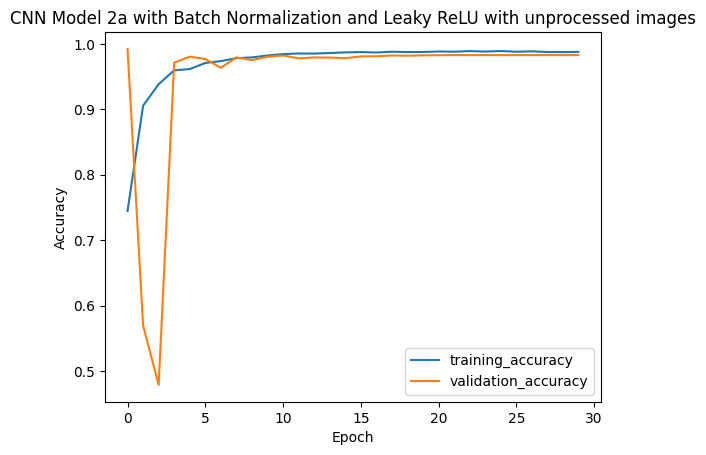

In [137]:
plot_model_accuracy(history_cnn_model_2a, title='CNN Model 2a with Batch Normalization and Leaky ReLU with unprocessed images', plot_params={'accuracy':'training_accuracy', 'val_accuracy': 'validation_accuracy'})


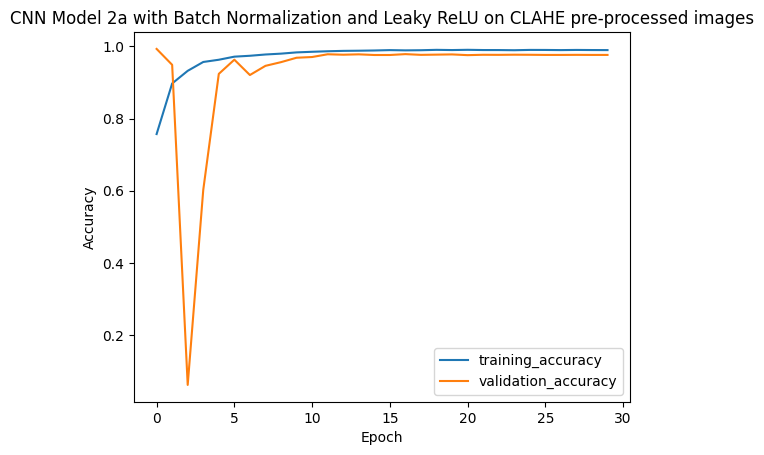

In [138]:
plot_model_accuracy(history_cnn_model_2b, title='CNN Model 2a with Batch Normalization and Leaky ReLU on CLAHE pre-processed images', plot_params={'accuracy':'training_accuracy', 'val_accuracy': 'validation_accuracy'})


###<b>Evaluating the model

In [139]:
model_cnn_2.evaluate(test_images_norm, test_labels_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9804 - loss: 0.0522


[0.10273677855730057, 0.9711538553237915]

In [140]:
model_cnn_2_clhae.evaluate(test_images_clahe_norm, test_labels_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9804 - loss: 0.0579


[0.09017259627580643, 0.9715384840965271]

<b> Generate the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


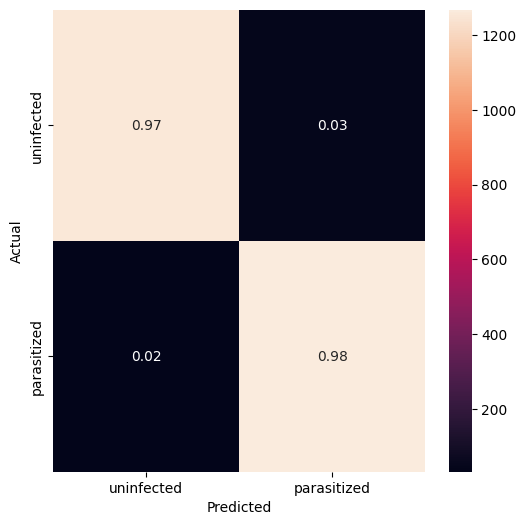

In [141]:
plot_confusion_matrix(model_cnn_2, test_images_norm, test_labels_encoded, use_pct=True)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


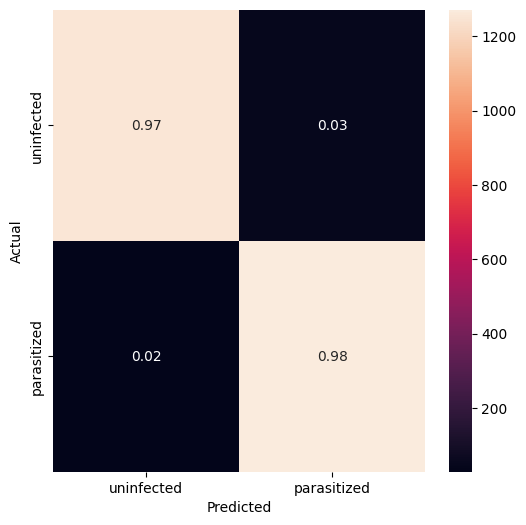

In [142]:
plot_confusion_matrix(model_cnn_2_clhae, test_images_clahe_norm, test_labels_encoded, use_pct=True)

#### <b>Observations and insights: ____ </b>
- For raw images:
1. Using Batch Normalization and Leak ReLU improved model performance in terms of accuracy from 97.7% (with Leaky RelU only) to 98.7%
2. Accuracy on validation sets also improved by 1 percentage point.
3. With this approach the False Positive and False Negative rates are at 2% which is an ideal balance.

- For CLHAE images:
1. The peformance is similar, but raw images perform better in terms of false positive rates, where CLHAE has 4% false positives vs 2% on raw images

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [143]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [144]:
backend.clear_session()
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

###<b> Use image data generator

In [145]:
# Do a horizontal flip, brightness adjustment, and rotate randomly up to 20 degrees
datagen_train = ImageDataGenerator(rotation_range=20,
                                   horizontal_flip = True,
                                   #brightness_range=[0.1, 0.2],
                                   fill_mode='nearest')

In [146]:
train_generator = datagen_train.flow(train_images_norm, train_labels_encoded, batch_size=64, shuffle=True)

In [147]:
train_images_norm.shape

(24958, 64, 64, 3)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

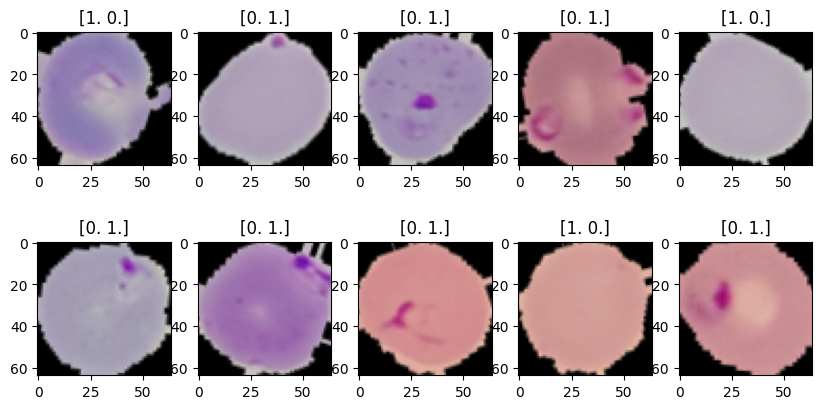

In [148]:
images, labels = next(train_generator)
#print(images.shape)
fig, ax = plt.subplots(2,5, figsize=(10,5))
ax = ax.flatten()

for i in range(0, 10):
  ax[i].imshow(images[i])
  ax[i].set_title(labels[i])

plt.show()


#### <b>Observations and insights: ____ </b>

1. We managed to create an image generator on the training set with flips and rotations
2. We visualized 10 random images and see that they look identical to the original training set but can very well be used as new data points for training
3. With more data and variation in images, the model should be likely to generalize better on unseen data.
4. datagen_train.flow transforms images in the training set randomly: not all images are augmented! Each image can be transformed differently over epochs



###<b>Building the Model

In [149]:
model_cnn_2_aug = build_cnn_model_2()

model_cnn_2_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [150]:
model_cnn_2_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,922 (2.04 MB)

 Trainable params: 533,730 (2.04 MB)

 Non-trainable params: 192 (768.00 B)

<b> Fit and Train the model

In [151]:
train_generator = datagen_train.flow(train_images_norm, train_labels_encoded, batch_size=64, shuffle=True)

history_cnn_model_2_aug = model_cnn_2_aug.fit(
      train_generator,
      steps_per_epoch=train_images_norm.shape[0] // 64,
      epochs=20,
      validation_data=(test_images_norm, test_labels_encoded),
      verbose=1,
      callbacks=[reduce_lr, early_stop]
    )


Epoch 1/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.6621 - loss: 0.7453 - val_accuracy: 0.5008 - val_loss: 1.8132 - learning_rate: 0.0010
Epoch 2/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.7344 - loss: 0.4897 - val_accuracy: 0.5000 - val_loss: 2.3883 - learning_rate: 0.0010
Epoch 3/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.8507 - loss: 0.3668 - val_accuracy: 0.7692 - val_loss: 0.4793 - learning_rate: 0.0010
Epoch 4/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.9219 - loss: 0.2486 - val_accuracy: 0.7915 - val_loss: 0.4434 - learning_rate: 0.0010
Epoch 5/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.9278 - loss: 0.2101 - val_accuracy: 0.5162 - val_loss: 1.2989 - learning_rate: 0.0010
Epoch 6/20
  1/389 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0431
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 1.0000 - loss

###<B>Evaluating the model

<b>Plot the train and validation accuracy

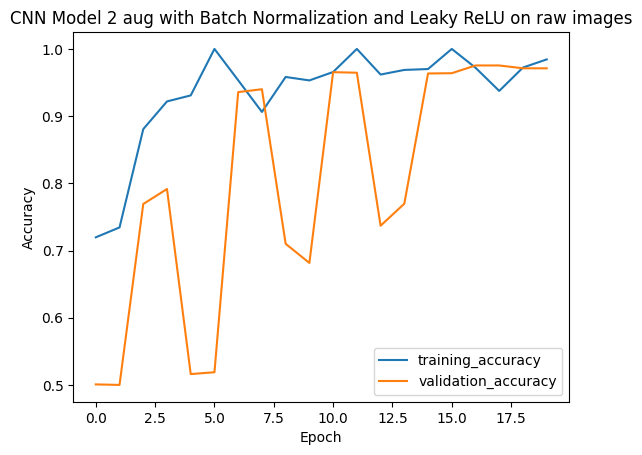

In [152]:
plot_model_accuracy(history_cnn_model_2_aug, title='CNN Model 2 aug with Batch Normalization and Leaky ReLU on raw images', plot_params={'accuracy':'training_accuracy', 'val_accuracy': 'validation_accuracy'})


<B>Plotting the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


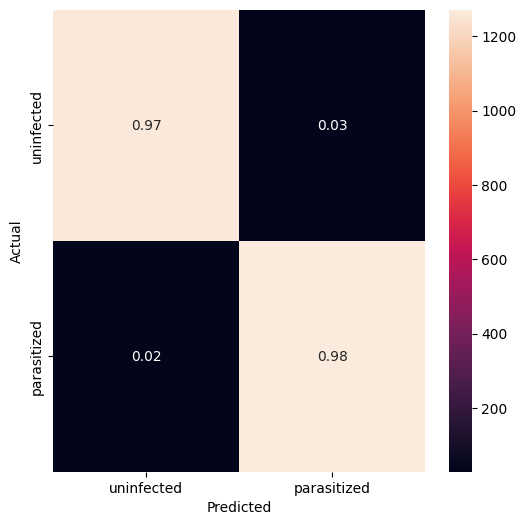

In [153]:
plot_confusion_matrix(model_cnn_2_aug, test_images_norm, test_labels_encoded, use_pct=True)

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [154]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [155]:
model = VGG16(weights='imagenet')
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [156]:
## Get only the convolution layers

transfer_layer = model.get_layer('block5_pool')
vgg_model_temp = Model(inputs=model.input, outputs=transfer_layer.output)

In [157]:
vgg_model_temp.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [158]:
backend.clear_session()

In [159]:
## Try another way

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [160]:
vgg_model.trainable=False

In [161]:
## we observe that the total params are now non-trainable
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

###<b>Compiling the model

In [162]:
new_vgg_model = Sequential(
    [
        vgg_model,
        Flatten(),
        Dense(64),
        LeakyReLU(alpha=0.1),
        # Second Fully connected layer
        Dense(64),
        LeakyReLU(alpha=0.1),
        Dense(2, activation='softmax')
    ]
)

In [164]:
new_vgg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,114 (56.65 MB)

 Trainable params: 135,426 (529.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [165]:
new_vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

<b>Fit and Train the model

In [166]:
history_vgg_model = new_vgg_model.fit(train_images, train_labels_encoded, validation_split=0.2, epochs=30, batch_size=32,
                shuffle=True, callbacks=[reduce_lr, early_stop])

Epoch 1/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9222 - loss: 0.2712 - val_accuracy: 0.9579 - val_loss: 0.1206 - learning_rate: 0.0010
Epoch 2/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9581 - loss: 0.1138 - val_accuracy: 0.9577 - val_loss: 0.1264 - learning_rate: 0.0010
Epoch 3/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9643 - loss: 0.0971 - val_accuracy: 0.9683 - val_loss: 0.1011 - learning_rate: 0.0010
Epoch 4/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9674 - loss: 0.0884 - val_accuracy: 0.9714 - val_loss: 0.0975 - learning_rate: 0.0010
Epoch 5/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9734 - loss: 0.0746 - val_accuracy: 0.9577 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 6/30
623/624 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9777 - loss: 0.0664
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9777 - loss: 0.0664 - v

<b>Plot the train and validation accuracy

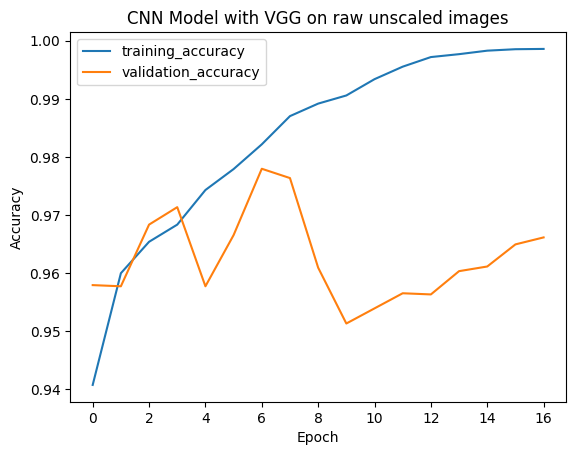

In [167]:
plot_model_accuracy(history_vgg_model, title='CNN Model with VGG on raw unscaled images', plot_params={'accuracy':'training_accuracy', 'val_accuracy': 'validation_accuracy'})


###**Observations and insights: _____**

*   What can be observed from the validation and train curves?
1. It appears that the model somewhat overfits on training data but on validation the performance varies between 94% to 97%.
2. We can address these gaps using data augmentation, dropout, etc. in the Dense/Decoder part of the model.

###<b> Evaluating the model

In [168]:
new_vgg_model.evaluate(test_images, test_labels_encoded)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9746 - loss: 0.0786


[0.11104854941368103, 0.9642307758331299]

<b>Plotting the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


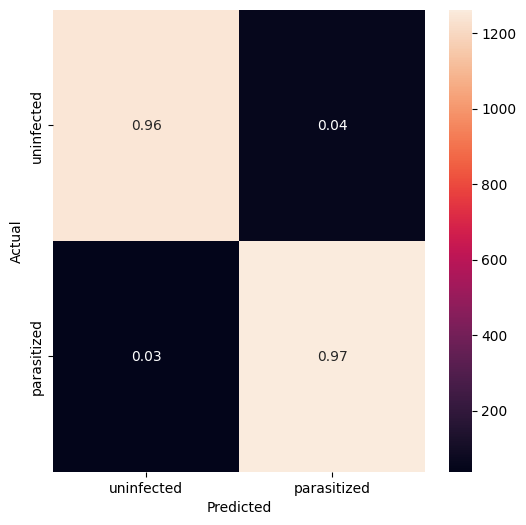

In [169]:
plot_confusion_matrix(new_vgg_model, test_images, test_labels_encoded, use_pct=True)

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


In [170]:
## Best model: CNN Model 2a with Batch Normalization and Leaky ReLU with unprocessed images
model_cnn_2.save('best_malaria_detection_model.keras')

#### <b> Observations and Conclusions drawn from the final model: _____ </b>
1. We tried several models, but the CNN model with Batch Normalization and Leaky ReLU on unprocessed images gave us a validation set accuracy of ~98% and balanced false positive and false negative rates of 2%


**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

#### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?
1. When we trained the base model with HSV, contrast enhanced images and unprocessed images, there was a meaningful difference in accuracy performance between those three datasets.
2. However, this difference grew narrower when we moved on to training with CNNs. Eventually, the unprocessed images performed better with Batch Normalization and Leaky ReLU.

#### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?
1. When we trained the Convolution model with the ReLU Activation function, the contrast enhanced image data performed significantly better than unprocessed and HSV transformed images.
2. Using He initialization with ReLU Activation on unprocessed images improved the model significantly with ~97% accuracy on validation set and 4% false positive and 3% false negative rates.
3. Using Batch Normalization and Leaky ReLU increased the accuracy of the model to ~98% with 2% false positive and 2% false negative rates. With this configuration in the model, both pre-processed and raw images have similar performance, albeit the unprocessed image has a lower false positive rate compared to the model trained on contrast enhanced images (2% vs 4%).
4. With data augmentation the performance remained similar as the previous model configuration.
5. With VGG we had a slightly worse accuracy on the validation set compared to the previous models.

#### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?
1. In my opinion, we should strive towards a model with the lowest false negative rate and the highest overall accuracy because we don't want to falsely detect no malaria when the red blood cells are in fact infected. This could cause the patient to go untreated and threaten their life.
2. The model we should go for is a CNN model with two convolution layers and one dense layer. This model should use batch normalization, leaky ReLU, and Max Pooling, optimizing for validation accuracy. In addition a "Reduce Learning Rate" callback function should be used to make sure the model converges at optimal rates and doesn't stall in improvements over epochs.
3. We should also augment the selected model with transformed images by applying rotations, flips, etc. to ensure that the model generalizes well beyond the training and validation sets. In microsopic images, it might be very common to have images that are rotated by various degrees and flips.
4. We should look into more image enhancement techniques to further improve model accuracy. Although such processes might be costly and if the incremental performance is not as much, then appropriate trade-offs between cost and benefits must be taken into account.